#Train a Deep Belief Network (DBN) using RBMs.

In [7]:
# Colab setup: ensure GPU, download dataset
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {device}')

# Download and unzip the F1 CSV dump
!wget -q https://ergast.com/downloads/f1db_csv.zip
!unzip -q f1db_csv.zip -d f1_data

Running on: cuda
replace f1_data/circuits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace f1_data/circuits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace f1_data/circuits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [17]:
# 1. LOAD + PREPROCESS
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load lap_times and races
laps = pd.read_csv('f1_data/lap_times.csv')
races = pd.read_csv('f1_data/races.csv')[['raceId','year','circuitId']]

# Merge to get year + circuit
laps = laps.merge(races, on='raceId', how='left')

# Convert 'time' (mm:ss.SSS) → seconds
def to_seconds(t):
    try:
        m,s = t.split(':')
        return int(m)*60 + float(s)
    except:
        return np.nan

laps['time_s'] = laps['time'].apply(to_seconds)
laps.dropna(subset=['time_s'], inplace=True)

# Select and one‑hot encode features
df = laps[['lap','position','time_s','year','circuitId']].rename(columns={'lap':'lap_no'})
df = pd.get_dummies(df, columns=['circuitId'])
print("Features shape:", df.shape)
print(df)

# Scale all columns to [0,1]
scaler = MinMaxScaler()
X = scaler.fit_transform(df.values.astype(float))

# Train/test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

Features shape: (589038, 45)
        lap_no  position  time_s  year  circuitId_1  circuitId_2  circuitId_3  \
0            1         1  98.109  2011         True        False        False   
1            2         1  93.006  2011         True        False        False   
2            3         1  92.713  2011         True        False        False   
3            4         1  92.803  2011         True        False        False   
4            5         1  92.342  2011         True        False        False   
...        ...       ...     ...   ...          ...          ...          ...   
589076      54        10  87.731  2024        False        False        False   
589077      55        10  87.781  2024        False        False        False   
589078      56        10  87.816  2024        False        False        False   
589079      57        10  88.554  2024        False        False        False   
589080      58        10  88.010  2024        False        False        False   

In [10]:
# 2. DEFINE GPU‐ENABLED Bernoulli RBM
import torch.nn as nn

class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))

    def sample_h(self, v):
        prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return prob, torch.bernoulli(prob)

    def sample_v(self, h):
        activation = F.linear(h, self.W.t(), self.v_bias)
        prob = torch.sigmoid(activation)
        return prob, torch.bernoulli(prob)

    def forward(self, v):
        _, h = self.sample_h(v)
        return h

    def free_energy(self, v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W, self.h_bias)
        hidden_term = torch.log1p(torch.exp(wx_b)).sum(1)
        return (-hidden_term - vbias_term).mean()

In [11]:
# 3. TRAIN FUNCTION FOR ONE RBM
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

def train_rbm(rbm, data, epochs=10, batch_size=64, lr=0.01):
    rbm.to(device)
    optim = torch.optim.Adam(rbm.parameters(), lr=lr)
    loader = DataLoader(TensorDataset(torch.tensor(data, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=True)
    losses = []
    for ep in range(epochs):
        epoch_loss = 0
        for batch, in loader:
            v0 = batch.to(device)
            # --- positive phase
            p_h0, h0 = rbm.sample_h(v0)
            # --- negative phase (CD‑1)
            p_v1, v1 = rbm.sample_v(h0)
            p_h1, _  = rbm.sample_h(v1)

            # update
            positive = torch.matmul(p_h0.t(), v0)
            negative = torch.matmul(p_h1.t(), v1)
            rbm.W.grad = -(positive - negative) / batch_size
            rbm.v_bias.grad = -(v0 - v1).mean(0)
            rbm.h_bias.grad = -(p_h0 - p_h1).mean(0)
            optim.step()
            optim.zero_grad()

            # track free energy
            epoch_loss += rbm.free_energy(v0).item()
        losses.append(epoch_loss / len(loader))
        print(f"Epoch {ep+1}/{epochs} — Free Energy: {losses[-1]:.4f}")
    # plot loss curve
    plt.plot(losses, marker='o')
    plt.title("Average Free Energy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Free Energy")
    plt.show()
    return rbm


Epoch 1/15 — Free Energy: -48.2635
Epoch 2/15 — Free Energy: -10.0321
Epoch 3/15 — Free Energy: -3.1984
Epoch 4/15 — Free Energy: -7.1892
Epoch 5/15 — Free Energy: -10.8327
Epoch 6/15 — Free Energy: -11.2525
Epoch 7/15 — Free Energy: -11.4072
Epoch 8/15 — Free Energy: -12.0663
Epoch 9/15 — Free Energy: -13.5522
Epoch 10/15 — Free Energy: -14.6606
Epoch 11/15 — Free Energy: -16.2754
Epoch 12/15 — Free Energy: -18.6220
Epoch 13/15 — Free Energy: -20.7444
Epoch 14/15 — Free Energy: -23.2045
Epoch 15/15 — Free Energy: -24.6826


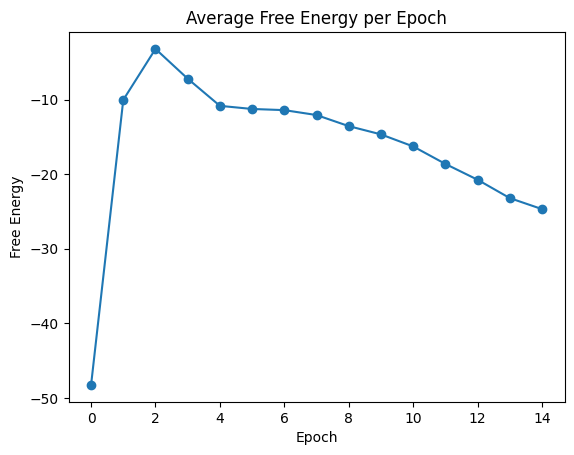

Epoch 1/10 — Free Energy: -72.8677
Epoch 2/10 — Free Energy: -104.7577
Epoch 3/10 — Free Energy: -120.2432
Epoch 4/10 — Free Energy: -132.5501
Epoch 5/10 — Free Energy: -145.3465
Epoch 6/10 — Free Energy: -159.3268
Epoch 7/10 — Free Energy: -169.3603
Epoch 8/10 — Free Energy: -180.3342
Epoch 9/10 — Free Energy: -188.3430
Epoch 10/10 — Free Energy: -196.1306


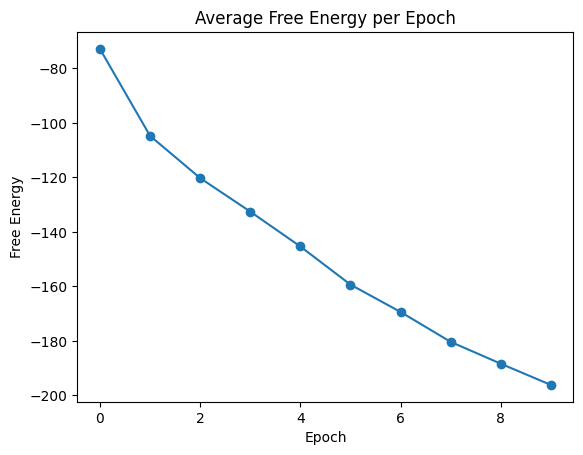

In [12]:
# 4. STACK & TRAIN YOUR DBN
# Layer sizes
n_vis = X_train.shape[1]
n_hid1 = 128
n_hid2 = 64

# First RBM
rbm1 = RBM(n_vis, n_hid1)
rbm1 = train_rbm(rbm1, X_train, epochs=15, batch_size=128, lr=0.01)

# Generate hidden activations to use as input for RBM2
with torch.no_grad():
    v = torch.tensor(X_train, dtype=torch.float32).to(device)
    p_h, _ = rbm1.sample_h(v)
hidden_train = p_h.cpu().numpy()

# Second RBM
rbm2 = RBM(n_hid1, n_hid2)
rbm2 = train_rbm(rbm2, hidden_train, epochs=10, batch_size=128, lr=0.01)


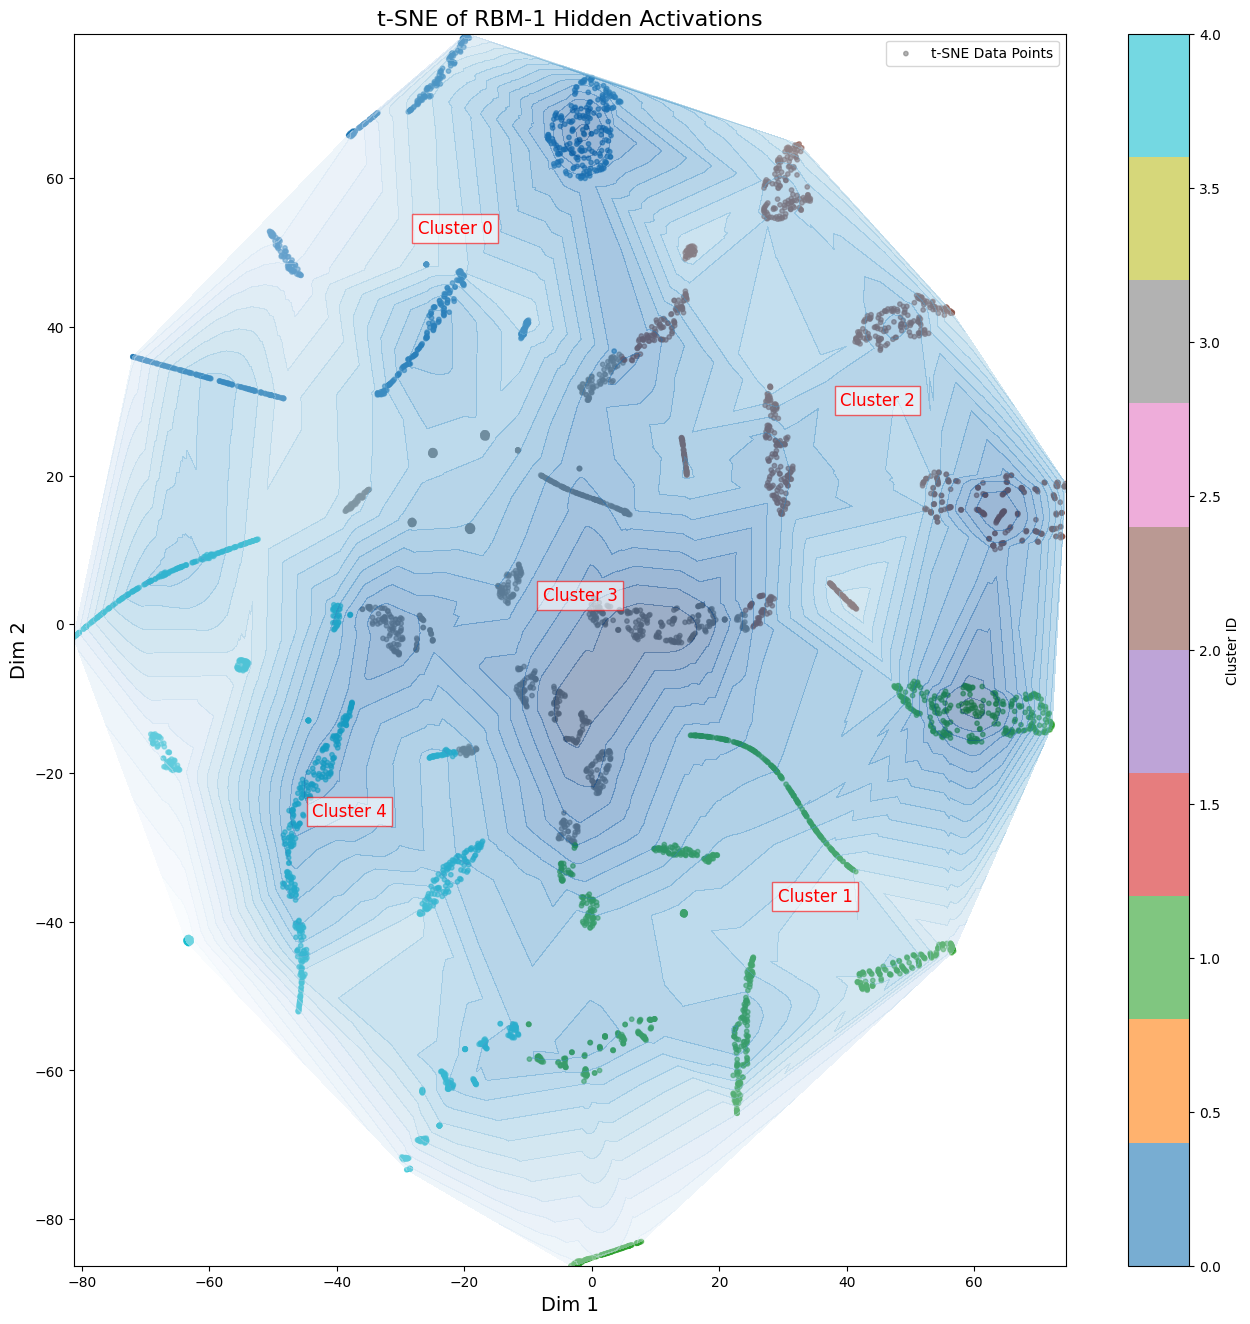

In [19]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import torch

# Compute hidden representations
with torch.no_grad():
    v = torch.tensor(X_train, dtype=torch.float32).to(device)
    p_h1, _ = rbm1.sample_h(v)
h1 = p_h1.cpu().numpy()

# Run t-SNE on a subset for speed
idx = np.random.choice(len(h1), size=5000, replace=False)
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
proj = tsne.fit_transform(h1[idx])

# Optional: Apply KMeans clustering
n_clusters = 5  # Choose the number of clusters based on data
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(proj)
clusters = kmeans.labels_

# Compute density for the plot
xy = np.vstack([proj[:, 0], proj[:, 1]])
density = gaussian_kde(xy)(xy)

# Plot t-SNE results with enhancements
plt.figure(figsize=(16, 16))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.6, label='Data Points')
plt.colorbar(scatter, label="Cluster ID")
plt.title("t‑SNE of RBM‑1 Hidden Activations", fontsize=16)
plt.xlabel("Dim 1", fontsize=14)
plt.ylabel("Dim 2", fontsize=14)

# Overlay density as a heatmap (optional)
plt.tricontourf(proj[:, 0], proj[:, 1], density, levels=20, cmap='Blues', alpha=0.4)

# Annotate key clusters or specific points
for cluster_id in range(n_clusters):
    cluster_center = kmeans.cluster_centers_[cluster_id]
    plt.annotate(f'Cluster {cluster_id}',
                 (cluster_center[0], cluster_center[1]),
                 fontsize=12, color='red',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='red'))

plt.legend(["t-SNE Data Points"])
plt.show()


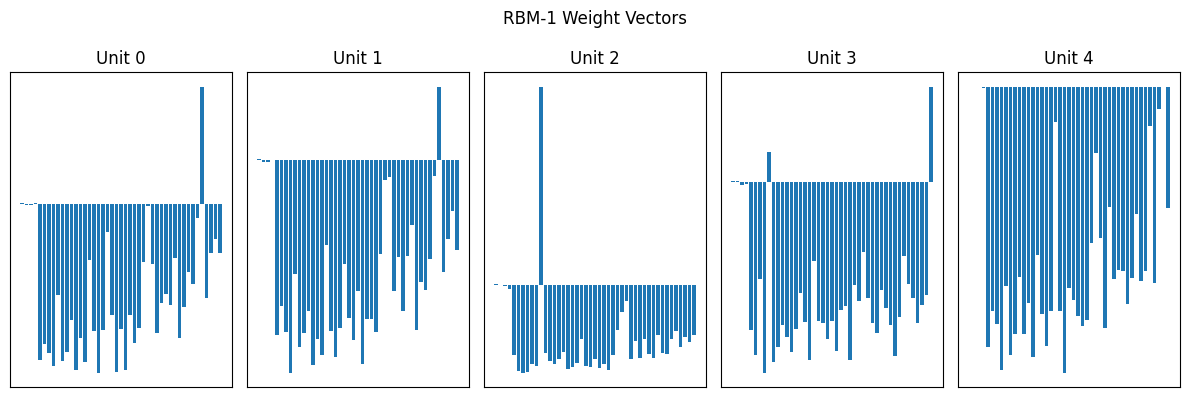

In [14]:
# 6. PLOT A FEW RBM‑1 WEIGHT VECTORS
plt.figure(figsize=(12,4))
for i, unit in enumerate([0,1,2,3,4]):
    plt.subplot(1,5,i+1)
    plt.bar(np.arange(n_vis), rbm1.W[i].detach().cpu().numpy())
    plt.xticks([]); plt.yticks([])
    plt.title(f"Unit {i}")
plt.suptitle("RBM‑1 Weight Vectors")
plt.tight_layout()
plt.show()


#Train a DBM for real-valued data representation.

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = 'Dakar_2022_fia_t1.csv'  # Make sure this is the correct path
data = pd.read_csv(file_path)

# Inspect the first few rows
print(data.head())

# Function to convert time string (e.g., '38H 33\' 03\'\'') to total seconds
def convert_time_to_seconds(time_str):
    try:
        time_parts = time_str.split('H')
        hours = int(time_parts[0].strip())
        minutes_seconds = time_parts[1].split("'")
        minutes = int(minutes_seconds[0].strip())
        seconds = int(minutes_seconds[1].replace('\'\'', '').strip())
        return hours * 3600 + minutes * 60 + seconds
    except:
        return None  # In case of NaN or incorrect format

# Convert the "TIME" and "GAP" columns to numeric (seconds)
data['TIME'] = data['TIME'].apply(convert_time_to_seconds)
data['GAP'] = data['GAP'].apply(convert_time_to_seconds)

# Handle missing values (if any)
data = data.fillna(data.select_dtypes(include=['float64', 'int64']).mean())  # Only fill numerical columns

# Select numerical columns only
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_data)

# Convert to PyTorch tensor
data_tensor = torch.FloatTensor(normalized_data)

# Inspect the resulting tensor
print(data_tensor.shape)  # Verify the tensor shape to ensure the data is loaded correctly


# Define the RBM (Restricted Boltzmann Machine)
class RBM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RBM, self).__init__()
        self.weights = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.1)
        self.visible_bias = nn.Parameter(torch.zeros(input_dim))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_dim))

    def sample_hidden(self, visible):
        return torch.sigmoid(torch.matmul(visible, self.weights) + self.hidden_bias)

    def sample_visible(self, hidden):
        return torch.sigmoid(torch.matmul(hidden, self.weights.t()) + self.visible_bias)

    def forward(self, visible):
        hidden = self.sample_hidden(visible)
        return hidden

# Define the DBN (Deep Belief Network) class
class DBN(nn.Module):
    def __init__(self, layers):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList([RBM(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.flatten = nn.Flatten()

    def forward(self, x):
        for rbm in self.rbms:
            x = rbm(x)
        x = self.flatten(x)  # Flatten the output to a 1D tensor
        return x

# Define the DBN architecture
layers = [data_tensor.shape[1], 512, 256, 128, 4]  # Last layer has 4 units to match input features
dbn = DBN(layers)

# Optimizer and loss function
optimizer = optim.Adam(dbn.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop for the DBN
epochs = 10
batch_size = 64

for epoch in range(epochs):
    for i in range(0, len(data_tensor), batch_size):
        batch = data_tensor[i:i+batch_size]

        # Forward pass
        output = dbn(batch)

        # Ensure the output size matches the batch size and features (e.g., 4 features)
        output = output.view(batch.size(0), -1)  # Flatten if necessary

        # Loss calculation
        loss = loss_fn(output, batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Extract features using the trained DBN
features = dbn.forward(data_tensor)

# Assuming 'labels' are available in your dataset, for example, using the 'POS.' column or another target column
labels = data['POS.'].values  # Adjust this based on your target column

# Train a classifier using the extracted DBN features
classifier = LogisticRegression()
classifier.fit(features.detach().numpy(), labels)

# Make predictions
predictions = classifier.predict(features.detach().numpy())

# Evaluate performance (e.g., using accuracy)
accuracy = accuracy_score(labels, predictions)
print(f"Classification accuracy: {accuracy}")

   POS.   N°                                         DRIVE-TEAM  \
0     1  201      (QAT) NASSER AL-ATTIYAH (AND) MATTHIEU BAUMEL   
1     2  211          (FRA) SEBASTIEN LOEB (BEL) FABIAN LURQUIN   
2     3  205            (SAU) YAZEED AL RAJHI (GBR) MICHAEL ORR   
3     4  221  (ARG) ORLANDO TERRANOVA (ESP) DANIEL OLIVERAS ...   
4     5  207       (ZAF) GINIEL DE VILLIERS (ZAF) DENNIS MURPHY   

                  TEAM          TIME           GAP      PENALITY  
0  TOYOTA GAZOO RACING  38H 33' 03''           NaN  00H 05' 00''  
1  BAHRAIN RAID XTREME  39H 00' 49''  00H 27' 46''  00H 05' 00''  
2     OVERDRIVE TOYOTA  39H 34' 16''  01H 01' 13''  00H 00' 35''  
3  BAHRAIN RAID XTREME  40H 00' 26''  01H 27' 23''  00H 13' 00''  
4  TOYOTA GAZOO RACING  40H 14' 51''  01H 41' 48''  00H 05' 00''  
torch.Size([70, 4])
Epoch 1/10, Loss: 2.9796907901763916
Epoch 2/10, Loss: 2.824270248413086
Epoch 3/10, Loss: 2.644615411758423
Epoch 4/10, Loss: 2.4831736087799072
Epoch 5/10, Loss: 2.352952957